# 训练垃圾短信过滤

## 加载模块

In [1]:
import sklearn
sklearn.__version__

'0.20.2'

In [2]:
%matplotlib inline
from io import open
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
import string
plt.style.use('ggplot')
# pd.options.display.mpl_style = 'default'

## 数据

数据来源: [wandouqiang/RubbishMessage](https://github.com/wandouqiang/RubbishMessage)

In [ ]:
!mkdir -p data && wget -c https://raw.githubusercontent.com/wandouqiang/RubbishMessage/master/data/80w.txt -O data/80w.txt

In [3]:
file_80w = './data/80w.txt'
with open(file_80w) as f:
    corpus = f.readlines()

print("共有{}条信息".format(len(corpus)))

corpus = [x.strip() for x in corpus]

for i,message in enumerate(corpus[:10]):
    print(i, message)

共有800000条信息
0 1	0	商业秘密的秘密性那是维系其商业价值和垄断地位的前提条件之一
1 2	1	南口阿玛施新春第一批限量春装到店啦         春暖花开淑女裙、冰蓝色公主衫   气质粉小西装、冰丝女王长半裙、   皇
2 3	0	带给我们大常州一场壮观的视觉盛宴
3 4	0	有原因不明的泌尿系统结石等
4 5	0	23年从盐城拉回来的麻麻的嫁妆
5 6	0	感到自减肥、跳减肥健美操、
6 7	1	感谢致电杭州萧山全金釜韩国烧烤店，本店位于金城路xxx号。韩式烧烤等，价格实惠、欢迎惠顾【全金釜韩国烧烤店】
7 8	0	这款UVe智能杀菌机器人是扫地机的最佳伴侣
8 9	1	一次价值xxx元王牌项目；可充值xxx元店内项目卡一张；可以参与V动好生活百分百抽奖机会一次！预约电话：xxxxxxxxxxx
9 10	0	此类皮肤特别容易招惹粉刺、黑头等


加载数据

In [4]:
with open(file_80w, encoding='UTF-8') as f:
    messages = pd.read_csv(f, sep='\t', quoting=csv.QUOTE_NONE, names=['label', 'message'])

messages['message'] = messages['message'].map(lambda text:text)
messages.head()

,label,message
1,0,商业秘密的秘密性那是维系其商业价值和垄断地位的前提条件之一
2,1,南口阿玛施新春第一批限量春装到店啦   春暖花开淑女裙、冰蓝色公主衫 ...
3,0,带给我们大常州一场壮观的视觉盛宴
4,0,有原因不明的泌尿系统结石等
5,0,23年从盐城拉回来的麻麻的嫁妆


In [5]:
# 使用2000条数据
messages = messages.sample(n=2000)

In [6]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        1809   1809                                      估计蜗壳是上了裁判小本本了    1
1         191    191  好消息：骆坪街农兴养猪合作社自产自销鲜肉批发部己于羊年正月初五正式启动！鲜肉零售直接降至xx...    1

In [7]:
messages['length'] = messages['message'].map(lambda text:len(text))
messages.head()

,label,message,length
290,0,他是那个喜欢偷偷亲Gary的光洙,16
357482,0,如刑事诉讼法、民事诉讼法、仲裁法等,17
504552,0,口碑相传品质教学无锡英之妆是您最佳的选择,20
326394,0,在今天召开的微软全球合作商大会上微软首席运营商KevinTurner透露Lumia520在相...,55
582765,1,你好，爱尚健身俱乐部，现招前台接待，底薪加提成，包住，月休xx天，月工资均达xxxx左右，有...,67


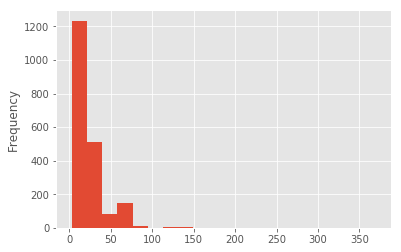

In [8]:
messages.length.plot(bins=20, kind='hist')

In [9]:
messages.length.describe()

count    2000.000000
mean       25.511500
std        19.899016
min         3.000000
25%        15.000000
50%        19.000000
75%        27.000000
max       370.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a22515278>,
      dtype=object)

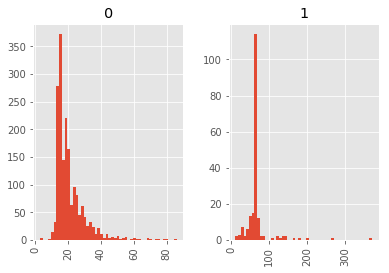

In [10]:
messages.hist(column='length', by='label', bins=50)

## 处理数据

使用 Jieba 进行分词，分词数据来源：[yanyiwu/iosjieba](https://github.com/yanyiwu/iosjieba)

In [ ]:
!mkdir dict
!wget -c https://raw.githubusercontent.com/yanyiwu/iosjieba/master/iosjieba/iosjieba.bundle/dict/jieba.dict.small.utf8 -O dict/jieba.dict.small.utf8
!wget -c https://raw.githubusercontent.com/yanyiwu/iosjieba/master/iosjieba/iosjieba.bundle/dict/user.dict.utf8 -O dict/user.dict.utf8

In [11]:
print("removing punctuations: "+string.punctuation)

import jieba
jieba.set_dictionary("./dict/jieba.dict.small.utf8")
jieba.load_userdict("./dict/user.dict.utf8")
jieba.initialize()

def tokenize(message):
    """ removes punctuation and tokenizes the words and stems each word.
    """
    msg = "".join([ch for ch in message if ch not in string.punctuation]) # get rid of punctuations
    stems = list(jieba.cut(msg, HMM=True))
    return stems

messages.message.head().apply(tokenize)

removing punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Building prefix dict from /Users/qiwihui/Development/nonWork/SMSFilters/model/dict/jieba.dict.small.utf8 ...
Loading model from cache /var/folders/kl/g94q0k_571vdjtcwzzcv20s40000gn/T/jieba.u863e59d49beec8805b7d0b2ea2fa7f35.cache
Loading model cost 0.335 seconds.
Prefix dict has been built succesfully.


290                      [他, 是, 那个, 喜欢, 偷偷, 亲, Gary, 的, 光洙]
357482                    [如, 刑事诉讼法, 、, 民事, 诉讼法, 、, 仲裁, 法等]
504552           [口碑, 相传, 品质, 教学, 无锡, 英之妆, 是, 您, 最佳, 的, 选择]
326394    [在, 今天, 召开, 的, 微软, 全球, 合作, 商, 大会, 上, 微软, 首席, 运...
582765    [你好, ，, 爱尚, 健身, 俱乐部, ，, 现招, 前台, 接待, ，, 底薪, 加, ...
Name: message, dtype: object

## 特征

特征抽取，TF-IDF

In [12]:
fv = CountVectorizer(analyzer=tokenize).fit(messages.message)

print("总词数", len(fv.vocabulary_))

总词数 9301


In [13]:
print("First:")
print(fv.transform(["你好"]))

print("Second:")
print(fv.transform(["好你"]))

First:
  (0, 1676)	1
Second:
  (0, 1674)	1
  (0, 3569)	1


In [ ]:
# print(messages.message[3])
# print(fv.transform([messages.message[3]]))

### TF

In [14]:
!mkdir -p result

In [15]:
def default(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError

import io
import json
with io.open("result/words_array.json",'w',encoding="utf-8") as outfile:
    outfile.write(str(json.dumps(fv.vocabulary_, ensure_ascii=False, default=default)))

## Messages Feature Vector

In [16]:
messages_fv = fv.transform(messages.message)
print(messages_fv.shape)

(2000, 9301)


In [17]:
tfidf = TfidfTransformer().fit(messages_fv)

In [ ]:
# test tfidf of same message as before.
# t = tfidf.transform(fv.transform([messages.message[3]]))
# print(t)

In [18]:
messages_tfidf = tfidf.transform(messages_fv)
print(messages_tfidf.shape)

(2000, 9301)


In [19]:
messages_tfidf[1]

<1x9301 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

### IDF

In [20]:
idf = {}
idf['idf'] = tfidf.idf_.tolist()

with io.open("result/words_idf.json",'w',encoding="utf-8") as outfile:
    outfile.write(str(json.dumps(idf, ensure_ascii=False)))

print("IDF of corpus :", tfidf.idf_)

IDF of corpus : [4.79473984 7.90825515 7.90825515 ... 7.90825515 5.71103058 6.99196442]


## 模型训练

Linear SVM

In [21]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(messages_tfidf, messages.label, test_size=0.33, random_state=42)

In [22]:
%time spam_detector = LinearSVC().fit(X_train, y_train)

predictions = spam_detector.predict(X_test)

print('accuracy', accuracy_score(y_test, predictions))
print('confusion matrix\n', confusion_matrix(y_test, predictions))
print('(row=expected, col=predicted)')

CPU times: user 5.54 ms, sys: 3.19 ms, total: 8.73 ms
Wall time: 9.66 ms
accuracy 0.9878787878787879
confusion matrix
 [[600   0]
 [  8  52]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

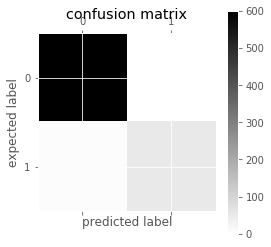

In [23]:
plt.matshow(confusion_matrix(y_test, predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       600
           1       1.00      0.87      0.93        60

   micro avg       0.99      0.99      0.99       660
   macro avg       0.99      0.93      0.96       660
weighted avg       0.99      0.99      0.99       660



## 转换为 CoreML

In [25]:
import coremltools
coreml_model = coremltools.converters.sklearn.convert(spam_detector, "message", "spam_or_not")

#set parameters of the model
coreml_model.author = "qiwihui"
coreml_model.license = "MIT"
coreml_model.short_description = "Classify whether message is spam or not"
coreml_model.input_description["message"] = "TFIDF of message to be classified"
coreml_model.output_description["spam_or_not"] = "Whether message is spam or not"
#save the model
coreml_model.save("result/SpamMessageClassifier.mlmodel")

In [26]:
from coremltools.models import MLModel
model = MLModel('result/SpamMessageClassifier.mlmodel')

model

input {
  name: "message"
  shortDescription: "TFIDF of message to be classified"
  type {
    multiArrayType {
      shape: 9301
      dataType: DOUBLE
    }
  }
}
output {
  name: "spam_or_not"
  shortDescription: "Whether message is spam or not"
  type {
    int64Type {
    }
  }
}
output {
  name: "classProbability"
  type {
    dictionaryType {
      int64KeyType {
      }
    }
  }
}
predictedFeatureName: "spam_or_not"
predictedProbabilitiesName: "classProbability"
metadata {
  shortDescription: "Classify whether message is spam or not"
  author: "qiwihui"
  license: "MIT"
}

In [ ]:
import json
words_array = json.load(open("result/words_array.json", 'r'))
print(len(words_array))

words_idf = json.load(open("result/words_idf.json", 'r'))
print(len(words_idf["idf"]))

In [ ]:
new_words_idf = {"idf": [round(idf, 3) for idf in words_idf["idf"]]}
with io.open("result/words_idf.json",'w',encoding="utf-8") as outfile:
    outfile.write(str(json.dumps(new_words_idf, ensure_ascii=False)))

## 参考

- [Building offline iPhone spam classifier using CoreML](https://medium.com/ymedialabs-innovation/building-offline-iphone-spam-classifier-using-coreml-3552c2beb2b2)